# Medical Image Segmentation - PDE, Deformable or Contour based methods 

#### In order to complete this laboratory task you should review the instruction file (Lab4_3 Instruction.pdf) beforehand. 

## TASK1) Constant Energy + Curvature

In [1]:
# Just for read
import cv2 # image processing and machine vision package
import numpy as np
from scipy import interpolate as ip
import matplotlib.pyplot as plt
from scipy.interpolate import spline
import scipy.ndimage as nd
from Functions1 import *

### As you can read in the instruction, we have to set an initial contour on the image as the first step. You can do it by using the function you wrote in the first lab (manually selecting points) as follow:


In [5]:
# Just for read.
# function for setting the points on the image and creating a mask.

refPt = [] # Selected points by user
flag = True # for right click checking

def Mask_Generator(shape,interpX,interpY): # Generate edge(mask) and filled(mask2) Masks
        mask = np.zeros(shape)
        for i in range(len(interpX)):
                mask[interpX[i],interpY[i]]=1
        a,b = shape
        mask2 = np.zeros(shape)
        for i in range(a):
                MaskRow = mask[i,:]
                Index = np.where(MaskRow==1)[0]
                if len(Index)==0:
                        continue
                SIndex = Index[0] # First index of ones from left
                EIndex = Index[-1]# First index of ones from right
                for j in range(SIndex,EIndex): # Fill between them!
                        mask2[i,j]=1
        return (mask,mask2)
# Open the image window for mouse clicks (for click_and_crop function)and as soon as flag gets false this will close the image window
def Selection(imageC):
        global refPt
        while flag:
                cv2.imshow('image', imageC)
                key = cv2.waitKey(10) & 0xFF
                if key == ord("z"): # break the loop if 'z' pressed. not necessary
                        break
def click_and_crop(event, x, y, flags, param): # event handler of clicks
        global refPt,flag,image
        if (event == cv2.EVENT_LBUTTONDOWN): # if left click:
                refPt.append((y, x))
                cv2.circle(imageC,(x,y),3,(255,0,0),-1)
        elif (event == cv2.EVENT_RBUTTONDOWN): # if right click:
                refPt.append((y, x))
                cv2.circle(imageC,(x,y),5,(0,255,255),-1)
                flag=False

In [6]:
# Just for read.
# Here we load the input image (a CT lung image) and select some arbitrary points to create a mask as initial contour.
# The output mask is which will be employed as initial contour named as "init_mask"
imgname = 'lung.jpg'
image = cv2.imread(imgname,0) # grayscale for process
imageC = cv2.imread(imgname)  # color for presentation
cv2.namedWindow("image")
cv2.setMouseCallback("image", click_and_crop)
Selection(imageC)
points = np.asarray(refPt)
LXs = points[:,0] # x of first selection
LXt = list(LXs)
LXt.append(points[0,0]) # add the first points to the end of the list for create circular structure
LXs = np.asarray(LXt)
LYs = points[:,1]
LYt = list(LYs)
LYt.append(points[0,1])
LYs = np.asarray(LYt)
tckL,uL = ip.splprep( [LXs,LYs] ,k=3 )
xnewL,ynewL = ip.splev( np.linspace( 0, 1, 1600 ), tckL,der = 0)
rounded_xnewL = np.int64(np.round_(xnewL))
rounded_ynewL = np.int64(np.round_(ynewL))
(lm,init_mask) = Mask_Generator(image.shape,rounded_xnewL,rounded_ynewL)

### Please note comparing to the instruction file, alpha and miu in notes are represented with Const and alpha respectively in code.

In [19]:
# TODOs
eps = np.finfo(float).eps # set a very small number(to prevent dividing by zero)
I = nd.imread('Lung.jpg', flatten=True)   #  read image for segmentation
I = I.astype(np.float)
# TODO set a maximum number of iteration
max_its= 20
display=True
# TODO set a constant speed 
Const = 100
# TODO set the coefficient of curvature term
alpha= 100
color='g'
# TODO a threshold value for stopping criteria
thresh = 0.1

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


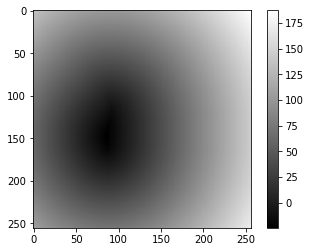

In [20]:
# TODO
# Call the function mask2phi and create a sign distance function for the initial contour; call it phi and plot it
phi=mask2phi(init_mask)
plt.imshow(phi,cmap='gray')
plt.colorbar()

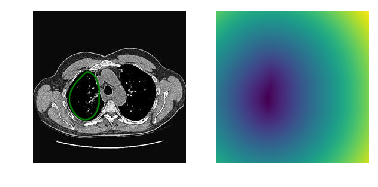

In [21]:
# just for read
# this part activates the displaying function which shows the contour evolution
if display:
    plt.ion()
    fig, axes = plt.subplots(ncols=2)
    show_curve_and_phi(fig, I, phi, color)

In [22]:
# just for read
# Main loop
its = 0
stop = False
prev_mask = init_mask
c = 0

iteration: 0


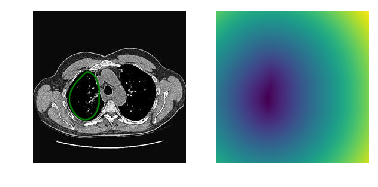

In [23]:
# TODO
# Complete the first condition of stopping criteria
while (its < max_its and not stop):
    # TODO: can you guess what is the role of idx? Get the image indexes outside the contour
    idx = np.flatnonzero(np.logical_and(phi <= 1.2, phi >= -1.2))

    if len(idx) > 0:
        # Intermediate output
        if display:
            if np.mod(its, 200) == 0:
                plt.ion()
                fig, axes = plt.subplots(ncols=2)
                print('iteration: {0}'.format(its))
                show_curve_and_phi(fig, I, phi, color)
        else:
            if np.mod(its, 10) == 0:
                print('iteration: {0}'.format(its))

        # TODO: call the function "get_curvature" and named it as "curvature"
        curvature = get_curvature(phi,idx)

        # TODO: implement energy functional (Constant Data term+alpha times curvature). name it as "dphidt"
        dphidt = Const+alpha*curvature

        # Maintain the Courant–Friedrichs–Lewy (CFL) condition 
        dt = 0.45 / (np.max(np.abs(dphidt)) + eps)

        # TODO: update the level set function only in the narrowband points such as X = X+dt*energy functional
        phi.flat[idx]+=dt*dphidt

        # Keep SDF smooth (Re-initialization process)
        phi = sussman(phi, 0.5)

        new_mask = phi <= 0
        c = convergence(prev_mask, new_mask, thresh, c)

        if c <= 5:
            its = its + 1
            prev_mask = new_mask
        else:
            stop = True

    else:
        break

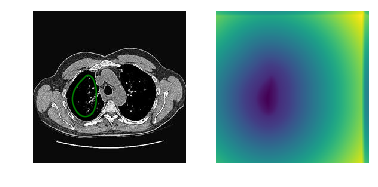

In [24]:
# Final output
if display:
    plt.ion()
    fig, axes = plt.subplots(ncols=2)
    show_curve_and_phi(fig, I, phi, color)

# Make mask from SDF
seg = phi <= 0  # Get mask from levelset

In [ ]:
#TODO
# Now change the parameters Const and Alpha value, play with them and find how they effect the evolution process.